## Day 21 Water

### Data

The establishment of the meteorological observatory of the University of Tartu laid the foundation for the hydrological observation network of Estonian inland waters. The observatory first measured the water level of the Emajõgi River in 1866, but more regular measurements began in the spring of 1867. Daily water level and regular flow measurements began on the Emajõgi River in 1922. In the 1920s, regular flow measurements were started on many other Estonian rivers.

From here it is possible to download the daily flow rates or drainage of the operating hydrometry stations. Information about operating stations can be found by clicking on the following link: https://www.ilmateenistus.ee/ilmateenistus/ Vaatlusvork/#hydro

The name of the station is followed by a homogeneous reference period, in this exercise we limit the periods of observation to the last 20 years in order to make the trends comparable.

- https://www.ilmateenistus.ee/siseveed/ajaloolised-vaatlusandmed/vooluhulgad/

In [1]:
import urllib.request

import pandas as pd
import numpy as np

import pymannkendall as mk

In [3]:
import urllib.request

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'TartuMapchallenger/100.0')]
urllib.request.install_opener(opener)

In [2]:
local_file, headers = urllib.request.urlretrieve("https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Reola-1986-2019.csv")

In [3]:
df = pd.read_csv(local_file, sep=';')

df['date2'] = df['Date'].apply(pd.to_datetime)

df['flow'] = df['Q [m3/s]'].apply(lambda x: x.replace('.', '').replace(',', '.')).apply(pd.to_numeric, errors='coerce')
df.head(5)

,Date,Q [m3/s],date2,flow
0,01.01.1986,"1,25",1986-01-01,1.25
1,02.01.1986,"1,16",1986-02-01,1.16
2,03.01.1986,"1,12",1986-03-01,1.12
3,04.01.1986,"1,11",1986-04-01,1.11
4,05.01.1986,"1,03",1986-05-01,1.03


In [4]:
df.dtypes

Date                object
Q [m3/s]            object
date2       datetime64[ns]
flow               float64
dtype: object

### Testing Mann-Kendall python package to calculate trend for flow timeseries

- https://www.researchgate.net/publication/334688255_pyMannKendall_a_python_package_for_non_parametric_Mann_Kendall_family_of_trend_tests
- https://pypi.org/project/pymannkendall/


In [5]:
result = mk.original_test(df['flow'].values)

print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.00582837501885014, z=-2.7572837517882007, Tau=-0.016497018249524435, s=-1272078.0, var_s=212845208288.0, slope=-5.4878718033146735e-06, intercept=1.2640741960267807)


### trying to get all the river station historical timeseries

https://www.dataquest.io/blog/web-scraping-tutorial-python/

In [3]:
import requests
page = requests.get("https://www.ilmateenistus.ee/siseveed/ajaloolised-vaatlusandmed/vooluhulgad/")
page

<Response [200]>

In [4]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page.content, 'html.parser')

In [5]:
"/html/body/section/div/div/article/section/table"

'/html/body/section/div/div/article/section/table'

In [6]:
t = soup.select('.table-override > tbody > tr > td > a')

In [7]:
len(t)

64

In [8]:
t

[<a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Aesoo-1929-2019.csv">1929-2019</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Ahja-1960-2019.csv">1960-2019</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Alajoe-1978-2019.csv">1978-2019</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Arbavere-2007-2019.csv">2007-2019</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Audru-2007-2019.csv">1986-1997,</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Audru-2007-2019.csv">2007-2019</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Elva-1981-1996_2009-2019.csv">1981-1996,</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Elva-1981-1996_2009-2019.csv">2009-2019</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Huuru_1968-2019.csv">1968-2019</a>,
 <a href="https://www.ilmateenistus.ee/wp-content/uploads/2

In [2]:
from time import sleep
from shutil import copyfile
from urllib.parse import urlparse

In [10]:
def pre_process(url):
    print(url)
    local_file, headers = urllib.request.urlretrieve(url)
    
    o = urlparse(url)
    filename = o.path.split('/')[-1]
    copyfile(local_file, filename)
    
    df = pd.read_csv(local_file, sep=';')
        
    df['date2'] = df['Date'].apply(pd.to_datetime)
    df['flow'] = df['Q [m3/s]'].apply(lambda x: x.replace('.', '').replace(',', '.')).apply(pd.to_numeric, errors='coerce')
    try:
        df2 = df.set_index('date2', verify_integrity=True)
    except ValueError as ex:
        print(f"{filename} date2 index verification failed")
        pass
    
    parqfile = filename.replace('.csv', '.parquet.gzip')
    df.to_parquet(parqfile, index=True, compression='gzip') 
    
    collector.append({'url': url,
                      'parquet': parqfile,
                     'csv': filename})
    
    print(filename)
    

In [ ]:
collector = []

for i in t:
    pre_process(i)
    sleep(30)

In [3]:
import toolz

In [4]:
from toolz.curried import pipe, map, filter, get, count


In [47]:
with open('target_urls.txt', 'w', encoding='utf8') as fh:
    for i in t:
        url = i['href']
        fh.write(f"{url}\n")

In [16]:
pd.DataFrame(collector).to_csv('collected_so_far.csv', encoding='utf8', index=False)

In [5]:
collector_df = pd.read_csv('collected_so_far.csv', encoding='utf8')

collector = []

for idx, row in collector_df.iterrows():
    collector.append({'url':row['url'],
                      'parquet': row['parquet'],
                     'csv': row['csv']})

In [14]:
with open('target_urls.txt', 'r', encoding='utf8') as fh:
    lines = fh.readlines()
    
    for line in lines:
        # url = i['href']
        url = line.strip()
        skip = filter( lambda x: x == url , map( get('url'), collector))
        if count(skip) == 0:
            pre_process(url)
            sleep(30)
        else:
            print("skip")

skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Reola-1986-2019.csv
Reola-1986-2019.csv date2 index verification failed
Reola-1986-2019.csv
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Riisa-1925-2019.csv
Riisa-1925-2019.csv
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Roostoja-1974-2019.csv
Roostoja-1974-2019.csv
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Rapina-1959-2019.csv
Rapina-1959-2019.csv
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Separa-2011-2019.csv
Separa-2011-2019.csv
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Sami-1942-2019.csv
Sami-1942-2019.csv
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Taheva-2007-2019.csv
Taheva-2007-2019.csv
https://www.ilmateenistus.ee/wp-content/uploads/2020/09/Tahkuse-1932-2019.csv
Tahkuse-1932-

In [6]:
collector_df.head()

,url,parquet,csv
0,https://www.ilmateenistus.ee/wp-content/upload...,Aesoo-1929-2019.parquet.gzip,Aesoo-1929-2019.csv
1,https://www.ilmateenistus.ee/wp-content/upload...,Ahja-1960-2019.parquet.gzip,Ahja-1960-2019.csv
2,https://www.ilmateenistus.ee/wp-content/upload...,Alajoe-1978-2019.parquet.gzip,Alajoe-1978-2019.csv
3,https://www.ilmateenistus.ee/wp-content/upload...,Arbavere-2007-2019.parquet.gzip,Arbavere-2007-2019.csv
4,https://www.ilmateenistus.ee/wp-content/upload...,Audru-2007-2019.parquet.gzip,Audru-2007-2019.csv


In [7]:
len(collector_df)

58

In [35]:
# Mann_Kendall_Test(trend='decreasing', h=True, p=0.00582837501885014, z=-2.7572837517882007, Tau=-0.016497018249524435, s=-1272078.0, var_s=212845208288.0, slope=-5.4878718033146735e-06, intercept=1.2640741960267807)

collector_df['trend'] = 'undefined'
collector_df['p'] = np.nan
collector_df['h'] = False
collector_df['slope'] = np.nan
collector_df['years'] = 0

In [38]:
for idx, row in collector_df.iterrows():
    test_df = pd.read_parquet(row['parquet'])
    
    test_df = test_df.loc[test_df['date2'] >= '1999-04']
    mind = test_df['date2'].min()
    maxd = test_df['date2'].max()
    years = int((maxd - mind).days / 365) 
    # test_df.dtypes
    print(f"{idx} {row['csv']} mind {mind} maxd {maxd} years {years}")
    
    result = mk.original_test(test_df['flow'].values)
    
    collector_df.loc[idx, 'years'] = years
    collector_df.loc[idx, 'trend'] = result.trend
    collector_df.loc[idx, 'p'] = result.p
    collector_df.loc[idx, 'h'] = result.h
    collector_df.loc[idx, 'slope'] = result.slope
    
    # break
    del result
    del test_df
    

0 Aesoo-1929-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
1 Ahja-1960-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
2 Alajoe-1978-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
3 Arbavere-2007-2019.csv mind 2007-01-01 00:00:00 maxd 2019-12-31 00:00:00 years 13
4 Audru-2007-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
5 Audru-2007-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
6 Elva-1981-1996_2009-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
7 Elva-1981-1996_2009-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
8 Huuru_1968-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
9 Kaansoo_1980-1966_2007-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
10 Kaansoo_1980-1966_2007-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-31 00:00:00 years 20
11 Kasari_1925-2019.csv mind 1999-04-01 00:00:00 maxd 2019-12-3

In [39]:
collector_df

,url,parquet,csv,trend,p,h,slope,years
0,https://www.ilmateenistus.ee/wp-content/upload...,Aesoo-1929-2019.parquet.gzip,Aesoo-1929-2019.csv,decreasing,3.228669e-02,True,-0.000045,20
1,https://www.ilmateenistus.ee/wp-content/upload...,Ahja-1960-2019.parquet.gzip,Ahja-1960-2019.csv,decreasing,8.881784e-15,True,-0.000084,20
2,https://www.ilmateenistus.ee/wp-content/upload...,Alajoe-1978-2019.parquet.gzip,Alajoe-1978-2019.csv,decreasing,2.059386e-04,True,-0.000016,20
3,https://www.ilmateenistus.ee/wp-content/upload...,Arbavere-2007-2019.parquet.gzip,Arbavere-2007-2019.csv,decreasing,1.738166e-07,True,-0.000067,13
4,https://www.ilmateenistus.ee/wp-content/upload...,Audru-2007-2019.parquet.gzip,Audru-2007-2019.csv,decreasing,0.000000e+00,True,-0.000167,20
5,https://www.ilmateenistus.ee/wp-content/upload...,Audru-2007-2019.parquet.gzip,Audru-2007-2019.csv,decreasing,0.000000e+00,True,-0.000167,20
6,https://www.ilmateenistus.ee/wp-content/upload...,Elva-1981-1996_2009-2019.parquet.gzip,Elva-1981-1996_2009-2019.csv,decreasing,0.000000e+00,True,-0.000133,20
7,https://www.ilmateenistus.ee/wp-content/upload...,Elva-1981-1996_2009-2019.parquet.gzip,Elva-1981-1996_2009-2019.csv,decreasing,0.000000e+00,True,-0.000133,20
8,https://www.ilmateenistus.ee/wp-content/upload...,Huuru_1968-2019.parquet.gzip,Huuru_1968-2019.csv,increasing,1.962894e-09,True,0.000028,20
9,https://www.ilmateenistus.ee/wp-content/upload...,Kaansoo_1980-1966_2007-2019.parquet.gzip,Kaansoo_1980-1966_2007-2019.csv,decreasing,0.000000e+00,True,-0.000067,20


In [ ]:
for idx, row in collector_df.iterrows():
    test_df = pd.read_parquet(row['parquet'])
    
    test_df = test_df.loc[test_df['date2'] >= '1999-04']
    mind = test_df['date2'].min()
    maxd = test_df['date2'].max()
    years = int((maxd - mind).days / 365) 
    # test_df.dtypes
    print(f"{idx} {row['csv']} mind {mind} maxd {maxd} years {years}")
    # break

In [26]:
years.days / 365

31.016438356164382

In [40]:
collector_df.to_parquet('calculated_flow_trends_estonia_last20years.parquet.gzip', index=False, compression='gzip') 

In [41]:
collector_df.head()

,url,parquet,csv,trend,p,h,slope,years
0,https://www.ilmateenistus.ee/wp-content/upload...,Aesoo-1929-2019.parquet.gzip,Aesoo-1929-2019.csv,decreasing,3.228669e-02,True,-0.000045,20
1,https://www.ilmateenistus.ee/wp-content/upload...,Ahja-1960-2019.parquet.gzip,Ahja-1960-2019.csv,decreasing,8.881784e-15,True,-0.000084,20
2,https://www.ilmateenistus.ee/wp-content/upload...,Alajoe-1978-2019.parquet.gzip,Alajoe-1978-2019.csv,decreasing,2.059386e-04,True,-0.000016,20
3,https://www.ilmateenistus.ee/wp-content/upload...,Arbavere-2007-2019.parquet.gzip,Arbavere-2007-2019.csv,decreasing,1.738166e-07,True,-0.000067,13
4,https://www.ilmateenistus.ee/wp-content/upload...,Audru-2007-2019.parquet.gzip,Audru-2007-2019.csv,decreasing,0.000000e+00,True,-0.000167,20


In [42]:
collector_df['trend'].value_counts()

decreasing    27
no trend      19
increasing    12
Name: trend, dtype: int64

In [43]:
import geopandas as gpd

stations = gpd.read_file(r'C:\dev\05_geodata\climate\stations\Estonia_ilmateenistus_3301.shp')

In [44]:
stations.head()

,stations,wmocode,longitude,latitude,ascii_sani,ID,INLET,PTSOURCE,RES,geometry
0,Kuressaare linn,None,22.48944444411111,58.26416666666667,kuressaare linn,1,0,0,0,POINT (411346.597 6459155.342)
1,Tallinn-Harku,26038,24.602891666624284,59.398122222355134,tallinn_harku,2,0,0,0,POINT (534250.544 6584618.823)
2,Pakri,26029,24.040080555476536,59.38950277719013,pakri,3,0,0,0,POINT (502277.599 6583505.345)
3,Kunda,26045,26.541397222079624,59.52141111042325,kunda,4,0,0,0,POINT (643825.046 6600924.969)
4,Jõhvi,26046,27.39827499992098,59.32902499979958,johvi,5,0,0,0,POINT (693367.350 6581666.569)


In [45]:
stations.sort_values(by='ascii_sani').head()

,stations,wmocode,longitude,latitude,ascii_sani,ID,INLET,PTSOURCE,RES,geometry
80,Aesoo,41137,25.061666666666667,58.515277777777776,aesoo,81,0,0,0,POINT (561868.455 6486615.048)
65,Ahja,41061,27.112222222222222,58.20916666666667,ahja,66,0,0,0,POINT (682888.074 6456274.862)
50,Alajõe,41163,27.392499999666665,59.03083333266667,alajoe,51,0,0,0,POINT (694718.298 6548475.264)
71,Arbavere,41080,25.96333333333333,59.43999999966667,arbavere,72,0,0,0,POINT (611386.884 6590760.518)
90,Audru,41196,24.318413888211627,58.423316666148345,audru,91,0,0,0,POINT (518604.844 6475927.043)


In [46]:
def parse_station(csv_file):
    elems = csv_file.replace('.csv', '').replace('_', '-').split('-')
    length = len(elems)
    name_parts = []
    for num in range(length-2):
        part = elems[num]
        try:
            int(part)
        except ValueError as ex:
            if num <= 2:
                name_parts.append(part.lower())
    
    return '_'.join(name_parts)

collector_df['station_name'] = collector_df['csv'].apply(parse_station)

In [47]:
collector_df.sample(3)

,url,parquet,csv,trend,p,h,slope,years,station_name
40,https://www.ilmateenistus.ee/wp-content/upload...,Sami-1942-2019.parquet.gzip,Sami-1942-2019.csv,decreasing,1.157115e-05,True,-0.000051,20,sami
1,https://www.ilmateenistus.ee/wp-content/upload...,Ahja-1960-2019.parquet.gzip,Ahja-1960-2019.csv,decreasing,8.881784e-15,True,-0.000084,20,ahja
49,https://www.ilmateenistus.ee/wp-content/upload...,Torva-1946-2019.parquet.gzip,Torva-1946-2019.csv,no trend,8.766029e-01,False,0.000000,20,torva


In [48]:
joined = pd.merge(stations, collector_df, left_on='ascii_sani', right_on='station_name', how='inner')

In [49]:
len(joined)

51

In [50]:
joined.sample()

,stations,wmocode,longitude,latitude,ascii_sani,ID,INLET,PTSOURCE,RES,geometry,url,parquet,csv,trend,p,h,slope,years,station_name
36,Aesoo,41137,25.061666666666667,58.515277777777776,aesoo,81,0,0,0,POINT (561868.455 6486615.048),https://www.ilmateenistus.ee/wp-content/upload...,Aesoo-1929-2019.parquet.gzip,Aesoo-1929-2019.csv,decreasing,0.032287,True,-0.000045,20,aesoo


In [51]:
joined

,stations,wmocode,longitude,latitude,ascii_sani,ID,INLET,PTSOURCE,RES,geometry,url,parquet,csv,trend,p,h,slope,years,station_name
0,Separa,41202,27.036666666333335,58.96611111111111,separa,43,0,0,0,POINT (674635.678 6540294.463),https://www.ilmateenistus.ee/wp-content/upload...,Separa-2011-2019.parquet.gzip,Separa-2011-2019.csv,no trend,2.074941e-01,False,-0.000024,9,separa
1,Uue-Lõve,41156,22.822222221555556,58.364444444444445,uue_love,44,0,0,0,POINT (431070.888 6469930.957),https://www.ilmateenistus.ee/wp-content/upload...,Uue-Love-1934-2019.parquet.gzip,Uue-Love-1934-2019.csv,no trend,8.776743e-01,False,0.000000,20,uue_love
2,Luguse,41154,22.71333333333333,58.81055555555555,luguse,45,0,0,0,POINT (425651.999 6519727.103),https://www.ilmateenistus.ee/wp-content/upload...,Luguse-1970-2019.parquet.gzip,Luguse-1970-2019.csv,no trend,1.611133e-01,False,-0.000002,20,luguse
3,Türi-Alliku,41158,25.47277777711111,58.82999999933334,turi_alliku,46,0,0,0,POINT (585052.969 6522113.600),https://www.ilmateenistus.ee/wp-content/upload...,Turi-Alliku-1971-1972_1977-2019.parquet.gzip,Turi-Alliku-1971-1972_1977-2019.csv,increasing,1.673874e-02,True,0.000031,20,turi_alliku
4,Hüüru,41103,24.53472222188889,59.379999999333336,huuru,47,0,0,0,POINT (530393.989 6582567.174),https://www.ilmateenistus.ee/wp-content/upload...,Huuru_1968-2019.parquet.gzip,Huuru_1968-2019.csv,increasing,1.962894e-09,True,0.000028,20,huuru
5,Pajupea,41097,24.96888888822222,59.38083333266667,pajupea,48,0,0,0,POINT (555069.656 6582936.592),https://www.ilmateenistus.ee/wp-content/upload...,Pajupea-1928-2019.parquet.gzip,Pajupea-1928-2019.csv,increasing,1.454438e-03,True,0.000006,20,pajupea
6,Kehra,41087,25.34027777744444,59.34416666633333,kehra,49,0,0,0,POINT (576257.831 6579216.003),https://www.ilmateenistus.ee/wp-content/upload...,Kehra_1982-2019.parquet.gzip,Kehra_1982-2019.csv,increasing,3.282582e-03,True,0.000059,20,kehra
7,Pudisoo,41085,25.59444444411111,59.50861111111111,pudisoo,50,0,0,0,POINT (590281.226 6597847.073),https://www.ilmateenistus.ee/wp-content/upload...,Pudisoo-1961-2019.parquet.gzip,Pudisoo-1961-2019.csv,increasing,1.285177e-06,True,0.000015,20,pudisoo
8,Alajõe,41163,27.392499999666665,59.03083333266667,alajoe,51,0,0,0,POINT (694718.298 6548475.264),https://www.ilmateenistus.ee/wp-content/upload...,Alajoe-1978-2019.parquet.gzip,Alajoe-1978-2019.csv,decreasing,2.059386e-04,True,-0.000016,20,alajoe
9,Tudulinna,41066,27.088333332999998,59.03666666633333,tudulinna,52,0,0,0,POINT (677243.176 6548280.941),https://www.ilmateenistus.ee/wp-content/upload...,Tudulinna-1956-2019.parquet.gzip,Tudulinna-1956-2019.csv,no trend,4.759545e-01,False,0.000002,20,tudulinna


In [52]:
type(joined)

geopandas.geodataframe.GeoDataFrame

In [53]:
eesti = gpd.read_file('../data_archive/estonia_without_lakes.shp')

In [54]:
eest3301 = eesti.to_crs(3301)

In [55]:
def renumber(x):
    d = {
        'decreasing': -1,
        'no trend':    0,
        'increasing':  1
    }
    return d.get(x, 0)

joined['trend_num'] = joined['trend'].apply(renumber)

In [56]:
joined['slope_abs'] = joined['slope'].apply(abs)

In [57]:
from sklearn import preprocessing

normalized_arr = preprocessing.normalize([joined['slope_abs'].values])

joined['slope_norm'] = normalized_arr[0]

In [58]:
normalized_arr.min()

0.0

In [59]:
# ( value - min ) / ( max - min ) * 20

minx = joined['slope_abs'].min()
maxx = joined['slope_abs'].max()
scale = 19

joined['slope_norm_man'] = 1 + ( joined['slope_abs'].values - minx ) / ( maxx - minx ) * scale

In [60]:
import mapclassify as mc

clf = mc.NaturalBreaks.make(k=20)

joined['slope_norm_class'] = 1 + joined[['slope_norm_man']].apply(clf)

In [61]:
joined[['slope_norm', 'slope_norm_man', 'slope_norm_class']].describe()

,slope_norm,slope_norm_man,slope_norm_class
count,51.000000,51.000000,51.000000
mean,0.100535,5.822295,8.058824
std,0.098440,4.721814,5.668904
min,0.000000,1.000000,1.000000
25%,0.024158,2.158775,3.000000
50%,0.074264,4.562155,7.000000
75%,0.162736,8.805834,12.500000
max,0.396112,20.000000,20.000000


In [62]:
joined.sample(3)

,stations,wmocode,longitude,latitude,ascii_sani,ID,INLET,PTSOURCE,RES,geometry,...,p,h,slope,years,station_name,trend_num,slope_abs,slope_norm,slope_norm_man,slope_norm_class
35,Oore,41127,24.76749999933333,58.463055555555556,oore,80,0,0,0,POINT (544793.382 6480565.219),...,0.009076,True,0.000313,20,oore,1,0.000313,0.396112,20.000000,20
19,Elva,41058,26.43444444411111,58.21138888888889,elva,65,0,0,0,POINT (643069.771 6454875.335),...,0.000000,True,-0.000133,20,elva,-1,0.000133,0.167977,9.057197,13
43,Kirumpää,41192,26.992499999666666,57.86555555555556,kirumpaa,87,0,0,0,POINT (677564.213 6417722.189),...,0.003651,True,-0.000245,5,kirumpaa,-1,0.000245,0.309792,15.859569,18


'kiru..'

<AxesSubplot:>

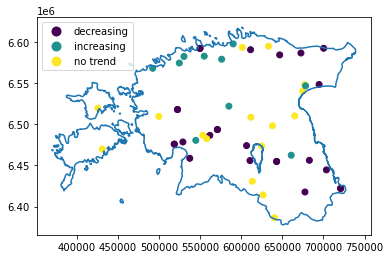

In [90]:
ax = eest3301.boundary.plot()

joined.plot(column='trend', categorical=True, legend=True, cmap='viridis', ax=ax)

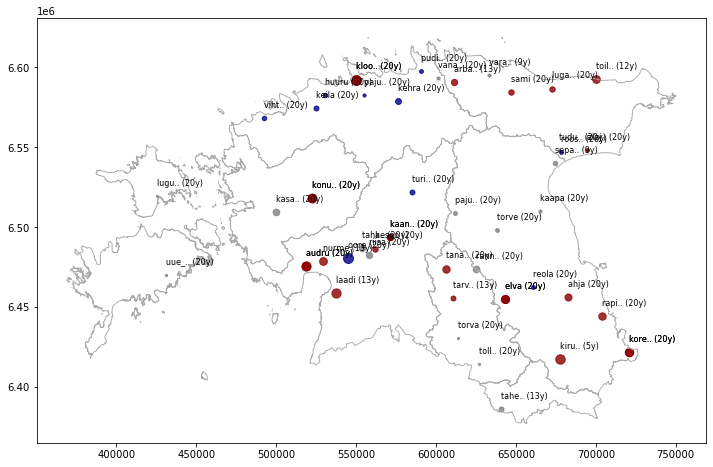

In [99]:
ax = landcatch.boundary.plot(color='darkgray', lw=0.9, figsize=(12,9))

clr = {
        'decreasing': 'darkred',
        'no trend':    'grey',
        'increasing':  'darkblue'
    }

for idx, row in joined.iterrows():
    tg = gpd.GeoDataFrame(pd.DataFrame(row).transpose(), geometry='geometry', crs=3301)
    msize = tg.iloc[0]['slope_norm_class'] * 5
    color = clr.get( tg.iloc[0]['trend'], 'grey' )
    tg.plot(ax=ax, color=color, markersize=msize, alpha=0.8 )
    stat_name = row['station_name'] if len(row['station_name']) < 6 else row['station_name'][0:4]+".."
    plt.text(tg['geometry'].x, row['geometry'].y,"{} ({}y)\n".format(stat_name, row['years']),size=8, color='black')

In [203]:
pd.DataFrame(row).transpose()

,stations,wmocode,longitude,latitude,ascii_sani,ID,INLET,PTSOURCE,RES,geometry,...,trend,p,h,slope,station_name,trend_num,slope_abs,slope_norm,slope_norm_man,slope_norm_class
50,Tarvastu,41199,25.88444444411111,58.23027777711111,tarvastu,93,0,0,0,POINT (610697.4923290922 6455937.669715327),...,decreasing,0,True,-3.5508e-05,tarvastu,-1,3.5508e-05,0.0643736,3.65436,10


In [65]:
import geoplot as gplt
import geoplot.crs as gcrs

<GeoAxesSubplot:>

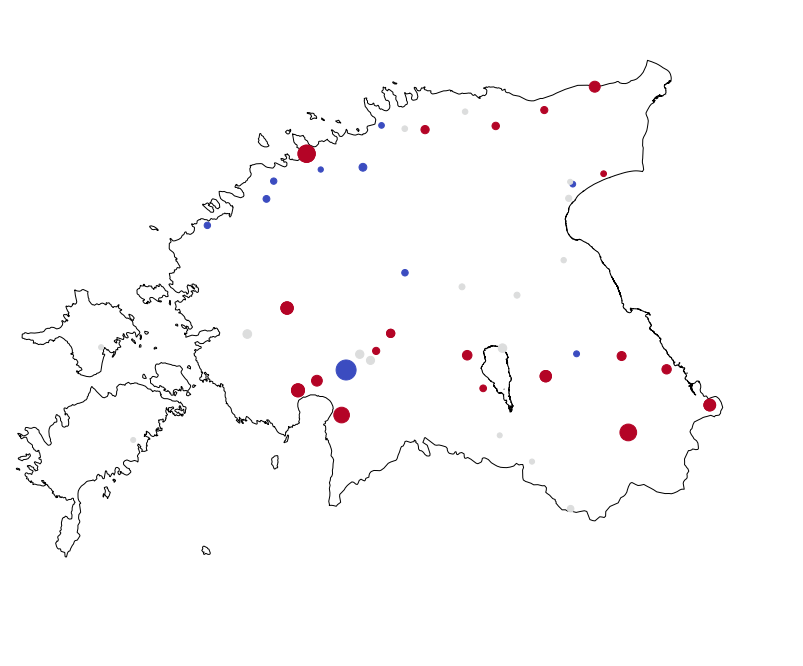

In [80]:
ax = gplt.polyplot(eest3301.to_crs(4326), projection=gcrs.EuroPP(), figsize=(15,12))

gplt.pointplot(
    joined.to_crs(4326), projection=gcrs.EuroPP(),
    hue='trend_num', cmap='coolwarm_r', ax=ax,
    scale='slope_norm', limits=(5, 20),
)

In [67]:
catchments = gpd.read_file(r'C:\dev\05_geodata\hydrological\catchments\21_water\alamvesikonnad_uus.shp')

<AxesSubplot:>

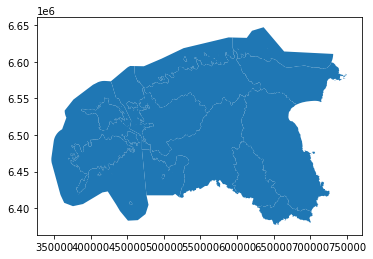

In [68]:
catchments.plot()

In [69]:
catchments.crs = 'EPSG:3301'

In [70]:
landcatch = catchments.loc[catchments['MAA_MERI'] == 1]

In [71]:
import contextily as ctx

In [72]:
cat84 = landcatch.to_crs(4326)
stat84 = joined.to_crs(4326)

Text(0.5, 1.0, 'Increasing (blue) and decreasing (red) trends in measured river flows in Estonian catchments over the last decades')

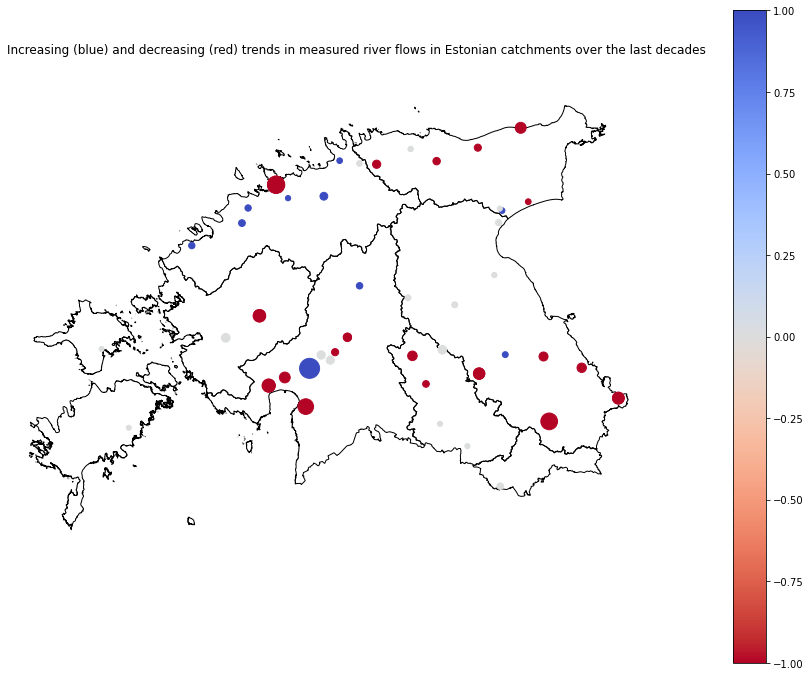

In [101]:
import matplotlib.pyplot as plt

ax = gplt.polyplot(cat84, projection=gcrs.EuroPP(), figsize=(15,12))

ax = gplt.pointplot(
    stat84, projection=gcrs.EuroPP(),
    hue='trend_num', cmap='coolwarm_r', ax=ax,
    scale='slope_norm_man', limits=(5, 20),
    legend=True,
    legend_var="hue"
)

plt.title("Increasing (blue) and decreasing (red) trends in measured river flows in Estonian catchments over the last decades")

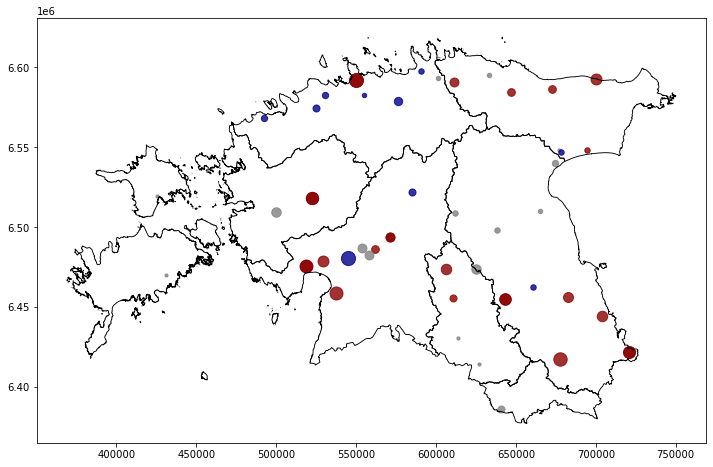

In [78]:
ax = landcatch.boundary.plot(color='black', lw=0.9, figsize=(12,9))

clr = {
        'decreasing': 'darkred',
        'no trend':    'grey',
        'increasing':  'darkblue'
    }

for idx, row in joined.iterrows():
    tg = gpd.GeoDataFrame(pd.DataFrame(row).transpose(), geometry='geometry', crs=3301)
    msize = tg.iloc[0]['slope_norm_class'] * 10
    color = clr.get( tg.iloc[0]['trend'], 'grey' )
    tg.plot(ax=ax, color=color, markersize=msize, alpha=0.8 )

In [104]:
for k, v in clr.items():
    print(v)
    
    # ,
           loc='lower left',
           ncol=2,
           mode='expand',
           fontsize=12

darkred
grey
darkblue


In [75]:
rivers = gpd.read_file('../data_archive/estonian_rivers.gpkg', layer='estonian_rivers_simpl', driver='GPKG')

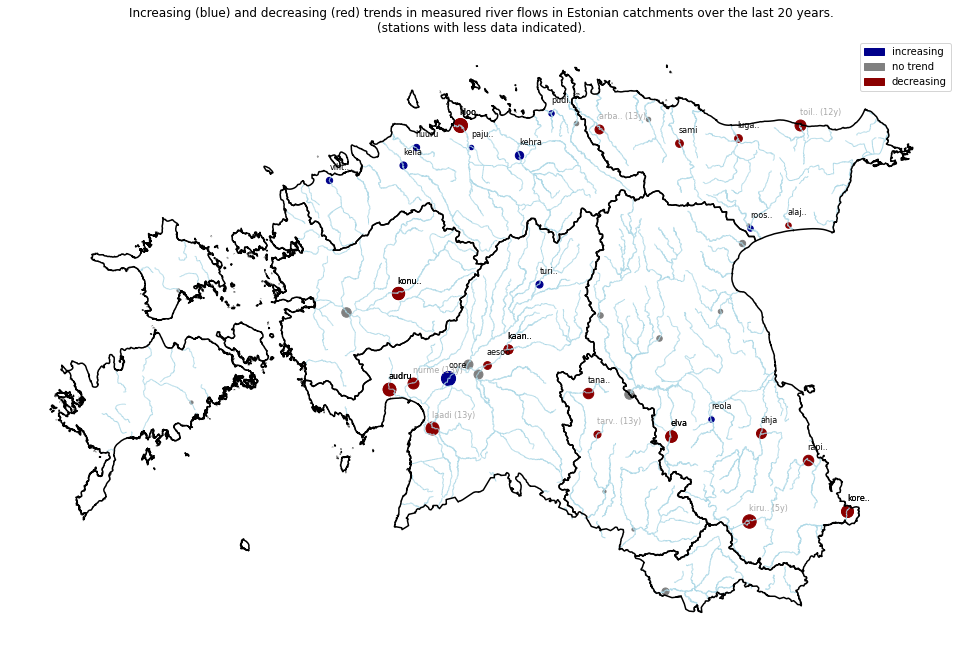

In [114]:
import matplotlib.patches as mpatches
import collections

patchList = []

clr = {
        'increasing':  'darkblue',
        'no trend':    'grey',
        'decreasing': 'darkred'
    }

for k, v in clr.items():
    data_key = mpatches.Patch(color=v, label=k)
    patchList.append(data_key)

fig, ax = plt.subplots(figsize=(17,16))

rivers.plot(ax=ax, color='lightblue', lw=1, alpha=1.0)

for idx, row in joined.iterrows():
    tg = gpd.GeoDataFrame(pd.DataFrame(row).transpose(), geometry='geometry', crs=3301)
    msize = tg.iloc[0]['slope_norm_class'] * 10
    color = clr.get( tg.iloc[0]['trend'], 'grey' )
    tg.plot(ax=ax, color=color, markersize=msize, alpha=1.0 )
    stat_name = row['station_name'] if len(row['station_name']) < 6 else row['station_name'][0:4]+".."
    if not tg.iloc[0]['trend'] == 'no trend':
        if row['years'] < 20:
            plt.text(tg['geometry'].x, row['geometry'].y,"{} ({}y)\n".format(stat_name, row['years']),size=8, color='darkgrey')
        else:
            plt.text(tg['geometry'].x, row['geometry'].y,"{}\n".format(stat_name),size=8, color='black')
    
landcatch.boundary.plot(color='black', ax = ax)



plt.legend(handles=patchList)
plt.axis('off')
plt.title("Increasing (blue) and decreasing (red) trends in measured river flows in Estonian catchments over the last 20 years.\n(stations with less data indicated).")
plt.savefig('../source/_static/day-21-water.png')
plt.show()